***we will:***

Clean text data 

Use Word2Vec to create word embeddings, and visualize the cluster of news headlines with similar title appearing togather with application of T-SNE for Dimensionality Reduction



**importing data**

In [ ]:
import pandas as pd

from google.colab import files
uploaded=files.upload()
import io
import numpy as np
dataset = pd.read_csv(io.BytesIO(uploaded['News_Final.csv']))

Saving News_Final.csv to News_Final.csv


In [ ]:
import numpy as np
import pandas as pd



In [ ]:
print(dataset.shape)

(93239, 11)


In [ ]:
dataset_bkp=dataset.copy()

**data Preprocessing:**

We'll start by doing some cleaning and manipulation on the text data.

In particular, we need to:

Get individual words from article titles

Use NLTK to filter out stopwords, punctuation, and any words that are not known to Word2Vec

Turn the words into vector representations using Word2Vec

In [ ]:
dataset_tites=dataset['Title']

title_list=[title for title in dataset_tites]

title_list_words=' '.join(title_list)

In [ ]:
#tokenize string into words
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
tokens=word_tokenize(title_list_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
token_punctuation=[ word for word in tokens if not word.isalpha()]#The isalpha() method returns True if all characters in the string are alphabets. If not, it returns False.

token_word=[word.lower()  for word in tokens if word.isalpha()]##The isalpha() method returns True if all characters in the string are alphabets. If not, it returns False.
                                                              ##lower is to turn it into lower case

In [ ]:
# Filter out stopwords
nltk.download('stopwords')#download stopwords
from nltk.corpus import stopwords
stopwords_eng=set(stopwords.words('english'))#import english stopwords

token_nonstop_words=[word for word in token_word if not word in stopwords_eng]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(len(token_nonstop_words))

585846


**download the google word2Vec model:**

In [ ]:
#Snippet to download the word2Vec model:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-05-26 15:03:13--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.138.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.138.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  88.3MB/s    in 17s     

2021-05-26 15:03:31 (90.7 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



**Load Word2Vec model (trained on an enormous Google corpus)**

In [ ]:
# Load Word2Vec model (trained on an enormous Google corpus)
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
print(model)
print(model.vector_size)# Check dimension of word vectors
print(type(model.vocab))#this is dictionary which contains all words in model
print(model['economy'].shape)#this gives word embedding found for economy word


300
<class 'dict'>
(300,)


In [ ]:
print((model['economy']))#word embedding for one word

[ 0.18847656 -0.0703125  -0.16113281  0.03857422 -0.04956055 -0.23046875
 -0.15722656 -0.16992188  0.17089844 -0.01208496 -0.16015625 -0.02770996
  0.05932617  0.00491333 -0.13769531  0.39257812  0.06201172  0.30859375
  0.12890625 -0.07373047 -0.07128906  0.26953125  0.22167969  0.04150391
 -0.01361084 -0.1953125   0.06884766 -0.04541016  0.36328125 -0.05761719
 -0.16308594 -0.45507812 -0.16699219 -0.09179688  0.15234375 -0.08984375
  0.33789062  0.01574707 -0.08789062  0.3984375  -0.03112793 -0.15234375
  0.30859375  0.23242188  0.08984375  0.0050354   0.25585938  0.24316406
 -0.27734375  0.171875    0.23144531  0.23242188 -0.12597656  0.03613281
  0.2890625   0.00469971 -0.02441406  0.31835938  0.19726562 -0.14257812
 -0.01867676  0.01495361 -0.37695312 -0.06298828  0.09814453 -0.04736328
 -0.02087402  0.01757812  0.06982422  0.01092529 -0.20605469 -0.09521484
  0.15917969 -0.03588867  0.02539062 -0.16503906  0.01916504  0.24316406
  0.07128906 -0.20507812 -0.07958984 -0.02307129 -0

In [ ]:
#access its model.wv property, which holds the standalone keyed vectors
word_vectors = model.wv.vocab


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in token_nonstop_words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in token_nonstop_words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df_word_vec = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_word_vec.shape

(21801, 300)

**Averaging Word Embeddings**

finding titles that cluster together, and seeing what patterns emerge.



In [ ]:
from nltk import word_tokenize 
def preprocess(text):
  text=text.lower()
  doc=word_tokenize(text)
  doc=[word for word in doc if word not in stopwords.words('english')]
  doc=[word for word in doc if word.isalpha()]
  return doc

In [ ]:
corpus= [ preprocess(title) for title in title_list]

In [ ]:

corpus_bkp=corpus.copy()

In [ ]:
print(corpus_bkp[0:100])


[['obama', 'lays', 'wreath', 'arlington', 'national', 'cemetery'], ['look', 'health', 'chinese', 'economy'], ['nouriel', 'roubini', 'global', 'economy', 'back'], ['finland', 'gdp', 'expands'], ['tourism', 'govt', 'spending', 'buoys', 'thai', 'economy', 'january'], ['intellitec', 'solutions', 'host', 'annual', 'spring', 'microsoft', 'dynamics', 'user', 'group'], ['monday', 'feb'], ['obama', 'stars', 'pay', 'musical', 'tribute', 'ray', 'charles'], ['fire', 'claims', 'barn', 'hancock', 'county'], ['microsoft', 'new', 'windows', 'ad', 'targets', 'apple'], ['microsoft', 'project', 'centennial', 'seen', 'universal', 'desktop', 'office'], ['microsoft', 'sneaks', 'onto', 'android', 'android', 'sneaks', 'onto', 'windows'], ['greek', 'economy', 'grows', 'pct', 'fourth', 'quarter'], ['big', 'data', 'internet', 'things', 'add', 'uk', 'economy', 'report'], ['hololens', 'dev', 'edition', 'costs', 'new', 'conker', 'game'], ['microsoft', 'word', 'mac', 'review', 'subtle', 'yet', 'massive', 'leap', 'fo

In [ ]:
doc_mean=list()

for doc in corpus_bkp:
   doc1=[word for word in doc if word in model.vocab]
   vect_doc1=[model[word] for word in doc1]
   mean_calc=np.mean(vect_doc1, axis=0)
   doc_mean.append(mean_calc)
       
        # The numpy.mean() function returns the arithmetic mean of elements in the array. If the axis is mentioned, it is calculated along it.axis=0 is for column


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print(type(doc_mean))
print(len(doc_mean))
print(type(doc_mean[0]))
print(doc_mean[0].shape)

<class 'list'>
93239
<class 'numpy.ndarray'>
(300,)


The fit() function calculates the values of these parameters. 

The transform function applies the values of the parameters on the actual data and gives the normalized value. 

The fit_transform() function performs both in the same step.

In [ ]:
print(doc_mean[:400])

[array([ 0.0412089 ,  0.10266113,  0.12239584,  0.11098226,  0.0797933 ,
       -0.16878255,  0.02546183, -0.04909261,  0.04600016, -0.05722554,
       -0.01485189, -0.06783041, -0.1677653 ,  0.07340495, -0.04199727,
        0.11098226, -0.11109034,  0.13546753, -0.0807902 , -0.06689453,
        0.04012044,  0.03607178,  0.02069092, -0.04715983, -0.0259196 ,
        0.03076172, -0.22680664,  0.01428223, -0.07307943, -0.07364909,
       -0.07917786,  0.0102946 , -0.15429688, -0.00756836,  0.04294841,
       -0.2388509 ,  0.09802246,  0.09925333,  0.04032389,  0.07176717,
       -0.04454549, -0.1605428 ,  0.16615804, -0.05151367, -0.05232747,
       -0.0991923 , -0.05791728, -0.04075114,  0.0222168 ,  0.02388   ,
       -0.07430013,  0.03491211,  0.0369873 , -0.00735474,  0.00520833,
       -0.07983398, -0.18147786, -0.07625326,  0.00967407, -0.04340108,
       -0.06433105,  0.03788249, -0.04706828,  0.03023275, -0.02144369,
       -0.08516439, -0.0602417 , -0.12121582,  0.02101644, -0.0

**Dimensionality Reduction with t-SNE**

In [ ]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,init='random',random_state=10,perplexity=100)
tsne_df=tsne.fit_transform(doc_mean[:400])
#tsne_df = tsne.fit_transform(X[:400])

In [ ]:
print(tsne_df)

[[ 2.80249429e+00 -2.68825507e+00]
 [ 1.23667634e+00  3.01281023e+00]
 [ 9.83630046e-02  3.82826066e+00]
 [-2.88488555e+00  1.26988661e+00]
 [ 1.56421244e+00  3.46639943e+00]
 [-1.48054016e+00 -3.93547726e+00]
 [ 4.08448553e+00 -5.84582996e+00]
 [ 2.81884599e+00 -2.92044806e+00]
 [ 2.04327846e+00 -2.57354093e+00]
 [-4.28104353e+00 -6.43020773e+00]
 [-2.37083936e+00 -5.28991508e+00]
 [-5.81343603e+00 -5.71429205e+00]
 [-2.12434006e+00  2.86291242e+00]
 [ 8.90871942e-01  2.11311078e+00]
 [ 1.24174857e+00 -3.99700308e+00]
 [-1.29769075e+00 -5.15076113e+00]
 [ 9.58690882e-01 -6.06420469e+00]
 [-2.96632099e+00 -5.55281496e+00]
 [-7.51058042e-01  2.32441020e+00]
 [ 1.75845969e+00  1.56368423e+00]
 [-3.61973429e+00 -9.47302818e+00]
 [-7.51066327e-01  2.32451653e+00]
 [-8.27681601e-01  1.40605962e+00]
 [-8.27527225e-01  1.40577304e+00]
 [ 7.15780854e-01 -1.66605115e+00]
 [-1.68093455e+00 -1.13686174e-01]
 [ 7.15837300e-01 -1.66643357e+00]
 [-2.17799902e+00 -7.67345619e+00]
 [-1.68095505e+00 -1

In [ ]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=b98296a859b5f30006c7e0af7e2e3794b14d599365918df626fd365e285f1604
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


**visualising the results for 1st 400 articles in cluster**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0, flags=flags)


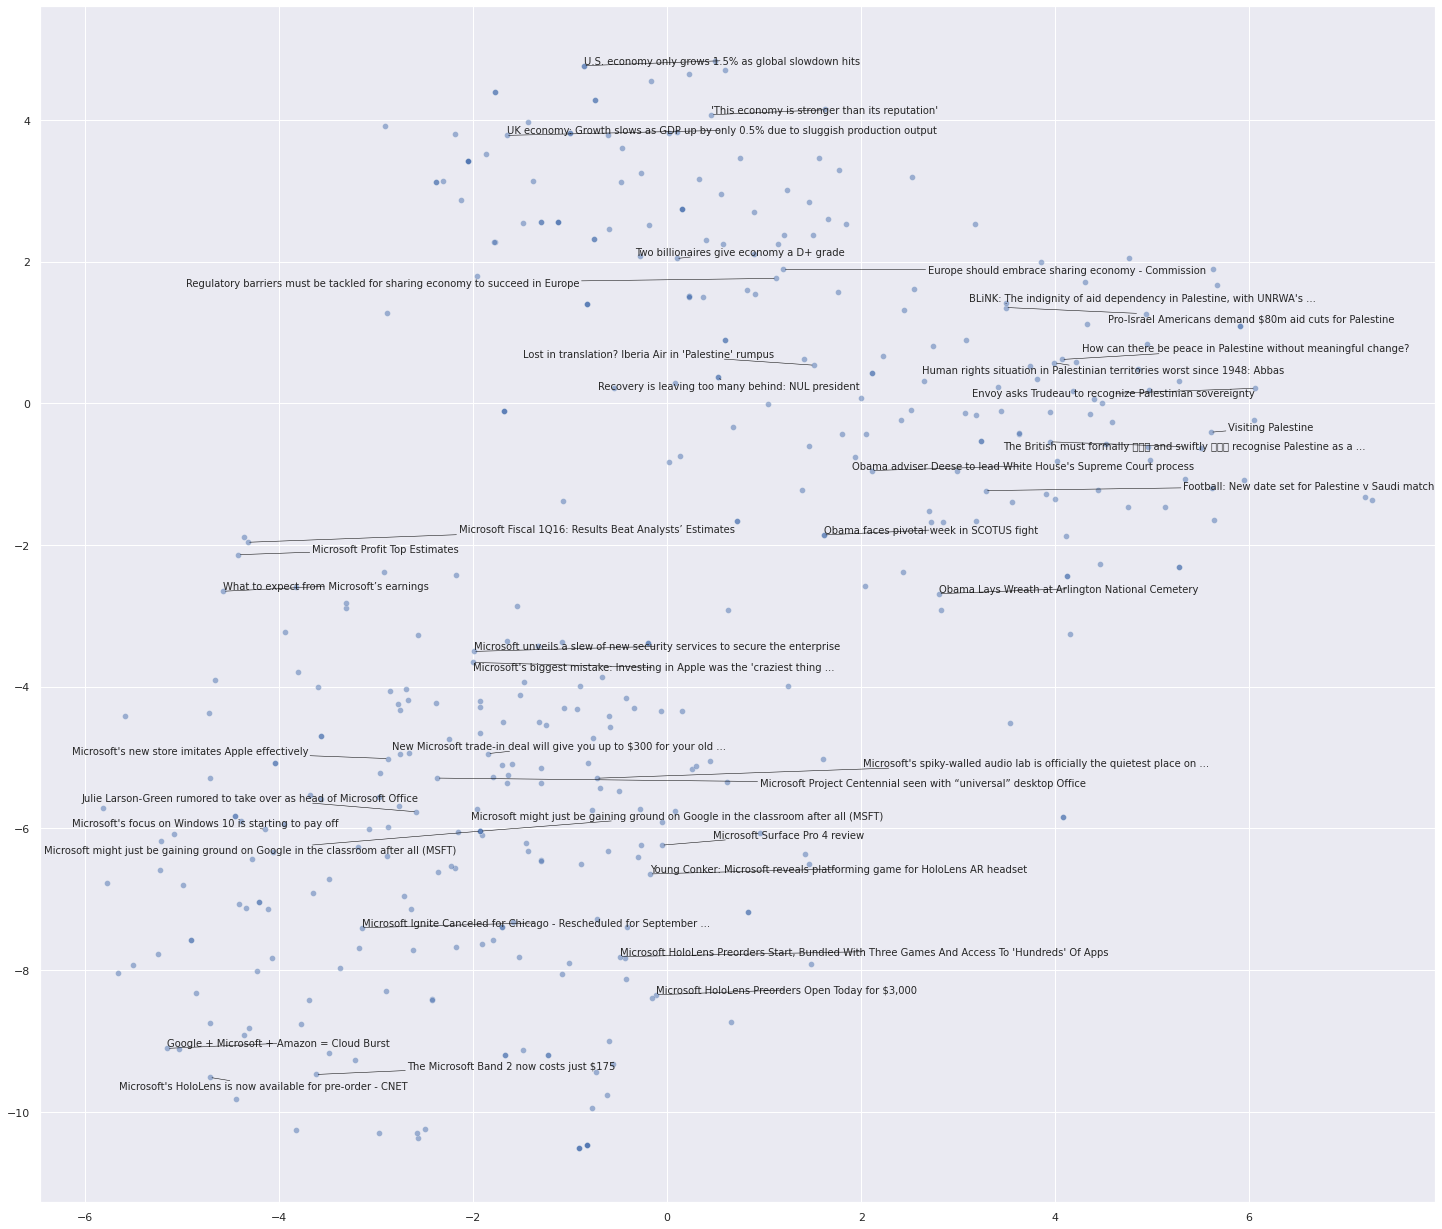

In [ ]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (25, 22))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)


# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 10)) # plots every 10th title in first 400 titles


# Append words to list
for title in titles_to_plot:
     texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], title_list[title], fontsize = 10))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [ ]:
print(titles_to_plot)
print(texts)
print(title_list[0:5])

[0, 40, 80, 120, 160, 200, 240, 280, 320, 360]
[Text(2.8024942874908447, -2.6882550716400146, 'Obama Lays Wreath at Arlington National Cemetery'), Text(-3.1343721216438993, -9.51490306854248, "Microsoft's HoloLens is now available for pre-order - CNET"), Text(2.8222465795528464, -1.8593322488212463, 'Obama faces pivotal week in SCOTUS fight'), Text(-1.1817048753396246, 1.7622535228729248, 'Regulatory barriers must be tackled for sharing economy to succeed in Europe'), Text(-3.6587610050420505, -4.9445695877075195, 'New Microsoft trade-in deal will give you up to $300 for your old ...'), Text(1.9363221591987079, -1.193608513007581, 'Football: New date set for Palestine v Saudi match'), Text(-3.890623309543937, -9.104762077331543, 'Google + Microsoft + Amazon = Cloud Burst'), Text(-4.609975185752139, -3.6574223041534424, "Microsoft's biggest mistake: Investing in Apple was the 'craziest thing ..."), Text(-3.7665037115949733, -5.766249656677246, 'Julie Larson-Green rumored to take over as